In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d prathamgrover/brain-tumor-classification

 98% 85.0M/86.8M [00:01<00:00, 64.6MB/s]
100% 86.8M/86.8M [00:01<00:00, 79.7MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/brain-tumor-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,BatchNormalization,Dropout
from tensorflow.keras.applications.vgg16 import VGG16

In [5]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(256,256,3)
)

58889256/58889256 [==============================] - 1s 0us/step


In [6]:
conv_base.trainable = True

set_trainable = False


# only train the block 1 layer that is true
for layer in conv_base.layers:
  if layer.name == "block3_conv1":
    set_trainable = True
  if layer.name == "block4_conv1":
    set_trainable = True
  if layer.name == "block5_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [18]:
# now add vgg16 model with this tranibale parameters
model = Sequential()

model.add(conv_base) # add vgg16 model
model.add(Flatten()) #flatten layer convert in to 1 d array
model.add(Dense(850,activation="elu",kernel_initializer="he_normal"))
model.add(Dropout(0.7))
model.add(BatchNormalization())
model.add(Dense(600,activation="elu",kernel_initializer="he_normal"))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(550,activation="elu",kernel_initializer="he_normal"))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(250,activation="elu",kernel_initializer="he_normal"))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(4,activation="softmax"))

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_5 (Dense)             (None, 850)               27853650  
                                                                 
 dropout (Dropout)           (None, 850)               0         
                                                                 
 batch_normalization_4 (Bat  (None, 850)               3400      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 600)               510600    
                                                      

In [32]:
# Now Do The Data Augmentation on this
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img

batch_size = 10

train_gen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_gen = ImageDataGenerator(rescale = 1./255)

train_data = train_gen.flow_from_directory(
    "/content/Training",
    target_size = (256,256),
    batch_size = batch_size,
    class_mode = 'categorical'
)

test_data = test_gen.flow_from_directory(
    "/content/Testing",
    target_size = (256,256),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

In [33]:
# now Compile the model
model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = "Adam",
    metrics = ["accuracy"]
)

In [34]:
history = model.fit_generator(train_data,epochs=10,validation_data=test_data,callbacks=[early_stopping])

Epoch 1/10
287/287 [==============================] - 75s 233ms/step - loss: 1.5068 - accuracy: 0.3331 - val_loss: 5.1913 - val_accuracy: 0.3223
Epoch 2/10
287/287 [==============================] - 66s 230ms/step - loss: 1.2722 - accuracy: 0.4268 - val_loss: 16243.1426 - val_accuracy: 0.3249
Epoch 3/10
287/287 [==============================] - 69s 240ms/step - loss: 1.2228 - accuracy: 0.4585 - val_loss: 105.1902 - val_accuracy: 0.2970
Epoch 4/10
287/287 [==============================] - 68s 238ms/step - loss: 1.1593 - accuracy: 0.4822 - val_loss: 27.8346 - val_accuracy: 0.3731
Epoch 5/10
287/287 [==============================] - 66s 231ms/step - loss: 1.0738 - accuracy: 0.5331 - val_loss: 21.2872 - val_accuracy: 0.3426
Epoch 6/10
287/287 [==============================] - 104s 364ms/step - loss: 1.0025 - accuracy: 0.5690 - val_loss: 69.6140 - val_accuracy: 0.3223


In [35]:
import pandas as pd
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.506802,0.333101,5.191273,0.322335
1,1.272249,0.426829,16243.142578,0.324873
2,1.222783,0.458537,105.190170,0.296954
3,1.159252,0.482230,27.834566,0.373096
4,1.073753,0.533101,21.287207,0.342640
5,1.002537,0.568990,69.614037,0.322335


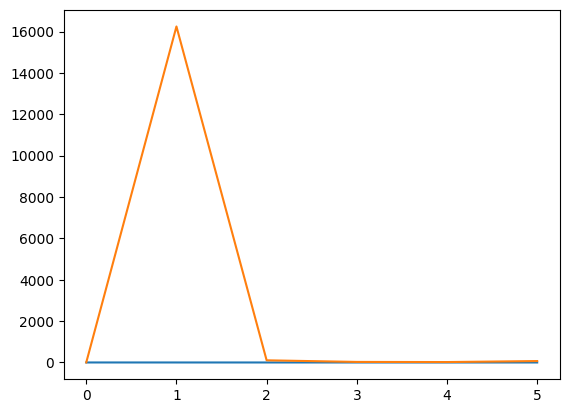

In [36]:
# plot and see the accuracy and loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

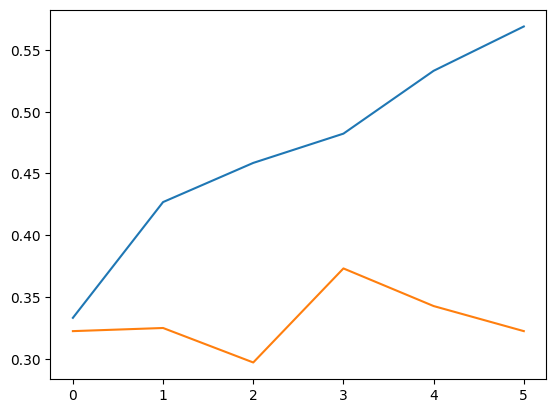

In [37]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

<Axes: >

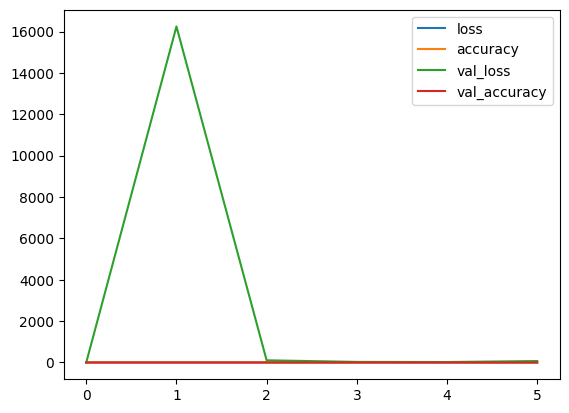

In [38]:
pd.DataFrame(history.history).plot()

In [39]:
brain = cv2.imread("/content/Training/glioma_tumor/gg (10).jpg")

In [40]:
brain.shape

(512, 512, 3)

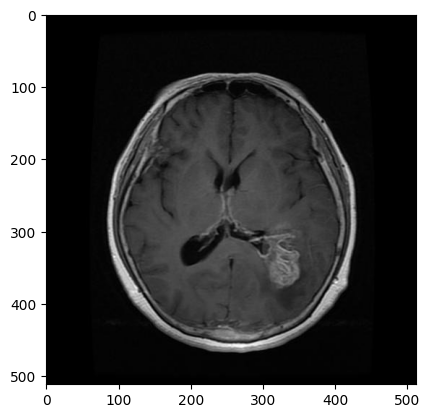

In [41]:
plt.imshow(brain)

In [42]:
test_image = cv2.resize(brain,(256,256))

In [43]:
test_input = test_image.reshape((1,256,256,3))

In [44]:
model.predict(test_input)

1/1 [==============================] - 0s 249ms/step


array([[5.3695762e-03, 7.4941505e-07, 2.9262108e-09, 9.9462962e-01]],
      dtype=float32)